In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import time
import sys
import re
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

import torch
from torch import nn
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader

from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy
from mvn.models.pose_hrnet import get_pose_net as get_pose_hrnet
from mvn.models.pose_resnet import get_pose_net as get_pose_resnet

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import multiview
from mvn.utils import volumetric
from mvn.utils import op
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.datasets.human36m import Human36MMultiViewDataset, Human36MTemporalDataset
from mvn.utils.misc import get_start_stop_frame_indxs, index_to_name, get_error_diffs, normalize_temporal_images_batch, retval, get_capacity

from train import setup_human36m_dataloaders

from mvn.models.triangulation import VolumetricTriangulationNet
from mvn.models.volumetric_adain import VolumetricTemporalAdaINNet
from mvn.models.volumetric_grid import VolumetricTemporalGridDeformation

from mvn.models.v2v import V2VModel

from IPython.core.debugger import set_trace

%matplotlib inline

retval = {
    'subject_names': ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'],
    'camera_names': ['54138969', '55011271', '58860488', '60457274'],
    'action_names': [
        'Directions-1', 'Directions-2',
        'Discussion-1', 'Discussion-2',
        'Eating-1', 'Eating-2',
        'Greeting-1', 'Greeting-2',
        'Phoning-1', 'Phoning-2',
        'Posing-1', 'Posing-2',
        'Purchases-1', 'Purchases-2',
        'Sitting-1', 'Sitting-2',
        'SittingDown-1', 'SittingDown-2',
        'Smoking-1', 'Smoking-2',
        'TakingPhoto-1', 'TakingPhoto-2',
        'Waiting-1', 'Waiting-2',
        'Walking-1', 'Walking-2',
        'WalkingDog-1', 'WalkingDog-2',
        'WalkingTogether-1', 'WalkingTogether-2']
}

JOINT_H36_DICT = {0:'RFoot',
                 1:'RKnee',
                 2:'RHip',
                 3:'LHip',
                 4:'LKnee',
                 5:'LFoot',
                 6:'Hip',
                 7:'Spine',
                 8:'Thorax',
                 9:'Head',
                 10:'RWrist',
                 11:'RElbow',
                 12:'RShoulder',
                 13:'LShoulder',
                 14:'LElbow',
                 15:'LWrist',
                 16:'Neck/Nose'}

JOINT_NAMES_DICT = {
                    0: "nose",
                    1: "left_eye",
                    2: "right_eye",
                    3: "left_ear",
                    4: "right_ear",
                    5: "left_shoulder",
                    6: "right_shoulder",
                    7: "left_elbow",
                    8: "right_elbow",
                    9: "left_wrist",
                    10: "right_wrist",
                    11: "left_hip",
                    12: "right_hip",
                    13: "left_knee",
                    14: "right_knee",
                    15: "left_ankle",
                    16: "right_ankle"
                }

CONNECTIVITY_DICT = {
    'cmu': [(0, 2), (0, 9), (1, 0), (1, 17), (2, 12), (3, 0), (4, 3), (5, 4), (6, 2), (7, 6), (8, 7), (9, 10), (10, 11), (12, 13), (13, 14), (15, 1), (16, 15), (17, 18)],
    'coco': [(0, 1), (0, 2), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16), (5, 6), (5, 11), (6, 12), (11, 12)],
    "mpii": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 9), (8, 12), (8, 13), (10, 11), (11, 12), (13, 14), (14, 15)],
    "human36m": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 16), (9, 16), (8, 12), (11, 12), (10, 11), (8, 13), (13, 14), (14, 15)],
    "kth": [(0, 1), (1, 2), (5, 4), (4, 3), (6, 7), (7, 8), (11, 10), (10, 9), (2, 3), (3, 9), (2, 8), (9, 12), (8, 12), (12, 13)],
}

device = 'cuda:0' #torch.cuda.current_device()
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True 

In [35]:
from torchvision.models.video.resnet import VideoResNet, BasicBlock, R2Plus1dStem, Conv2Plus1D
VideoResNet()

# Unpack tensorboard

In [2]:
# from tensorboard.backend.event_processing import event_accumulator
# d = {}
# exp_path = '../logs/resnet_50'
# names = [
#     'stack_3d/h36_sv32_dist_stack-pose-noloss-3d-interpolate-gn_s2v-v2v-v1-256-32-gn_vf32_f2v-features-noupscale-C0-256-group_resnet50-gn-nostylegrad_dt-12_dil-3-1-1_lr-1e-4@24.03.2020-22:26:39',
#     'baseline/h36_sv32_dist_resnet50-gn_v2v-v1-gn-no-aggr_1-1_lr-1e-4@17.03.2020-15:30:45',
#     'baseline/h36_sv32_dist_resnet50-bn_v2v-v1-bn-no-aggr_1-1_lr-1e-4@17.03.2020-15:32:32',
#     'stack_3d/h36_sv32_dist_stack3d-interpolate-gn_s2v-v2v-v1-256-128-64-32-gn_vf32_f2v-features-noupscale-C0-256-group_resnet50-gn-nostylegrad_dt-6_dil-3-3-3_lr-1e-4@25.03.2020-17:12:59'
# ]
# for name in tqdm_notebook(names): #(os.listdir(exp_path))
# #     exp_path = os.path.join(root, exp_type)
# #     for name in tqdm_notebook(os.listdir(exp_path)):
#     path = os.path.join(exp_path, name, 'tb')
#     path = os.path.join(path, os.listdir(path)[0])
#     ea = event_accumulator.EventAccumulator(path, size_guidance={ # see below regarding this argument
#                                             event_accumulator.COMPRESSED_HISTOGRAMS: 0,
#                                             event_accumulator.IMAGES: 0,
#                                             event_accumulator.AUDIO: 0,
#                                             event_accumulator.SCALARS: 100,
#                                             event_accumulator.HISTOGRAMS: 0,
#                                             })

#     ea.Reload()

#     if 'val/dataset_metric_epoch' in ea.Tags()['scalars']:
#         full_name = name
#         dataset_metric_epoch = [event.value for event in ea.Scalars('val/dataset_metric_epoch')]
#         d[full_name] = dataset_metric_epoch
#     else:
#         print (f'Name {full_name} skipped')

In [3]:
# # baseline_name_bn = 'baseline/h36_sv32_dist_resnet50-bn_v2v-v1-bn-no-aggr_1-1_lr-1e-4@17.03.2020-15:32:32'
# # label1 = 'Baseline Batch Normalization'
# plt.figure(figsize=(10,5), dpi=180)
# plt.plot(d[names[2]][:16], label = 'Baseline Batch Normalization')
# plt.plot(d[names[1]][:16], label = 'Baseline Group Normalization')
# plt.plot(d[names[3]][:16], label = 'Stack3D model with Pose-Motion disentanglement')
# plt.xlabel('Epoch')
# plt.ylabel('Validation MPJPE')
# plt.legend()
# plt.show()


# # name1 = names[0]
# # label1 = 'SPADE3D'

# # name2 = names[1]
# # label2 = 'STACK3D'

# # N = 200

# # plt.figure(figsize=(10,5), dpi=180)
# # # plt.plot(d[baseline_name_bn][:N], label=label1, linewidth=1.)
# # plt.plot(d[name1][:N], label=label1, linewidth=1.)
# # plt.plot(d[name2][:N], label=label2, linewidth=1.)
# # plt.xlabel('Epoch')
# # plt.ylabel('Training Decoder loss (weighted by 1e-4)')
# # plt.legend()
# # plt.show()

In [4]:
# special_name = 'h36_sv32_dist_baseline_v2v-v1-BN_resnet152-BN_bs-1-1_norot_softmax_15k@12.02.2020-19:52:43'
# path = os.path.join(root, special_name, 'tb')
# path = os.path.join(path, os.listdir(path)[0])
# ea = event_accumulator.EventAccumulator(path, size_guidance={ # see below regarding this argument
#                                         event_accumulator.COMPRESSED_HISTOGRAMS: 0,
#                                         event_accumulator.IMAGES: 0,
#                                         event_accumulator.AUDIO: 0,
#                                         event_accumulator.SCALARS: 100,
#                                         event_accumulator.HISTOGRAMS: 0,
#                                         })

# ea.Reload()

# l2_1 = [event.value for event in ea.Scalars('val/dataset_metric_epoch')]


# special_name = 'h36_sv32_dist_baseline_v2v-v1-BN_resnet152-BN_bs-1-1_norot_softmax_15k@12.02.2020-19:52:43'
# path = os.path.join(root, special_name, 'tb')
# path = os.path.join(path, os.listdir(path)[0])
# ea = event_accumulator.EventAccumulator(path, size_guidance={ # see below regarding this argument
#                                         event_accumulator.COMPRESSED_HISTOGRAMS: 0,
#                                         event_accumulator.IMAGES: 0,
#                                         event_accumulator.AUDIO: 0,
#                                         event_accumulator.SCALARS: 100,
#                                         event_accumulator.HISTOGRAMS: 0,
#                                         })

# ea.Reload()

# l2_2 = [event.value for event in ea.Scalars('val/dataset_metric_epoch')]

In [5]:

# experiment_type='resnet_50_3d'
# experiment_name='h36_sv32_dist_spade3d-h128-interpolate-gn-bn-conf-leakyrelu_s2v-R2D-2l-RGB-64-1e-4_vf64_resnet50-gn_dt-6_dil-3-1-1_lr-1e-4_norot_gradclip-1e-2@10.04.2020-17:06:07'

experiment_type='resnet_50_3d'
experiment_name='h36_sv32_dist_spade3d-h128-unproject-gn-bn-conf-leakyrelu_s2v-R2D-upscale-3l-RGB-112-64-1e-4_vf64_resnet50-gn_dt-10_dil-1_bs1-1_lr-1e-4_norot_gradclip-1e-2@17.04.2020-15:27:46'

# experiment_type='resnet_50_3d'
# experiment_name='h36_sv32_dist_stack3d-interpolate-gn_s2v-v2v-256-128-64-32-gn-decoder-1e-4_vf32_f2v-features-noupscale-C0-256-group_resnet50-gn-nostylegrad_dt-11-intermediate_dil-3-1-1_lr-1e-4_norot@03.04.2020-10:37:42'

experiment_root = os.path.join('../logs/', experiment_type, experiment_name)
config_path = experiment_root + '/config.yaml'

config = cfg.load_config(config_path)
config.dataset.val.retain_every_n_frames_in_test = 1

_, val_loader, _ = setup_human36m_dataloaders(config,
                                             is_train=False,
                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.keypoints_per_frame if hasattr(config.dataset, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)


Batch size: 1 
 dt: 10 
 dilation: 1 
 pivot_type: first 
 pivot_position: -1 
 keypoints_per_frame False


# Check dataset output

In [6]:
# for batch in islice(val_loader, 3):

#     n_views = batch['images'].shape[1]
#     batch_size = batch['images'].shape[0]
    
#     fig, axes = plt.subplots(ncols=n_views, nrows=1, figsize=(5 * n_views, 5))
#     for i in range(n_views):
#         # first row
#         detection = batch['detections'][0][i]
#         *bbox, c = detection
        
#         image = batch['images'][0][i]
#         image = denormalize_image(image).astype(np.uint8)
#         image = image[..., ::-1]  # bgr -> rgb
#         camera_name = batch['cameras'][i][0].name
#         title = "{}, detection conf: {:.3}".format(camera_name, c)
        
#         # second row
#         keypoints_3d = batch['keypoints_3d'][0][:, :3]
#         proj_matrix = batch['cameras'][i][0].projection
# #         image_shape_before_resize = batch['image_shapes_before_resize'][0][i]
#         image_shape = image.shape[:2]

#         keypoints_2d_wrt_new = multiview.project_3d_points_to_image_plane_without_distortion(proj_matrix, keypoints_3d)
# #         keypoints_2d_wrt_orig = transform_points_after_crop_and_resize(keypoints_2d_wrt_new, (bbox[0], bbox[1]), image_shape_before_resize, image_shape, forward=True)
        
#         axes[i].set_xlim(0, image.shape[1])
#         axes[i].set_ylim(0, image.shape[0])
#         axes[i].invert_yaxis()
#         axes[i].imshow(image)
#         axes[i].scatter(keypoints_2d_wrt_new[:, 0], keypoints_2d_wrt_new[:, 1], s=10, c='red')
        
#         axes[i].axis('off')
#     plt.show()

# Model

In [7]:
# config.model.cuboid_multiplier = 1.0
# config.model.rotation = False
# config.model.transfer_cmu_to_human36m = False
# config.model.encoder_normalization_type = 'group_norm'
# config.model.upscale_bottleneck = False
# config.model.f2v_intermediate_channels = config.model.intermediate_channels    
# config.model.f2v_normalization_type = 'group_norm'   
# config.model.v2v_type = 'v1'
# config.model.spade_broadcasting_type = 'unprojecting'

model = {
    "vol": VolumetricTriangulationNet,
    "vol_temporal_adain":VolumetricTemporalAdaINNet
}[config.model.name](config, device=device).to(device)

print ('Loaded {} model'.format(config.model.name))

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone
Only resnet50 backbone is used...
backbone:  34.0M
motion_extractor:  75.97M
volume_net:  57.39M
process_features:  0.02M
Loaded vol_temporal_adain model


# Check distr

In [8]:
# me = model.motion_extractor.motion_extractor
# ups =  model.motion_extractor.final_layer
# me_p = []
# for p in me.parameters():
#     me_p.append(p.flatten())
# me_p = torch.cat(me_p).detach().cpu().numpy()
# plt.figure(figsize=(10,10))
# plt.hist(me_p, bins=1000)
# plt.yscale('log', nonposy='clip')
# plt.show()

# ups_p = []
# for p in ups.parameters():
#     ups_p.append(p.flatten())
# ups_p = torch.cat(ups_p).detach().cpu().numpy()
# plt.figure(figsize=(10,10))
# plt.hist(ups_p, bins=1000)
# plt.yscale('log', nonposy='clip')
# plt.show()

# Load weights

In [9]:
checkpoints_path = experiment_root + '/checkpoints/'
weights_path = checkpoints_path + '/weights.pth'
weights_dict = torch.load(weights_path)['model_state'] # , map_location=device
REBUILD_STATE_DICT = False

if REBUILD_STATE_DICT:
    model_dict = model.state_dict()
    new_pretrained_state_dict = {}

    for k, v in weights_dict.items():
        if k in model_dict:
            new_pretrained_state_dict[k] = weights_dict[k]
        
    model.load_state_dict(new_pretrained_state_dict, strict=True)
else:
    model.load_state_dict(weights_dict, strict=True)
    
print ('Done')

Done


In [10]:
# for batch in train_loader:
#     images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch = dataset_utils.prepare_batch(batch, device)
#     break

# (keypoints_3d_pred, 
# features_pred, 
# volumes_pred, 
# confidences_pred, 
# cuboids_pred, 
# coord_volumes_pred, 
# base_points_pred) = model(images_batch, batch)    

# Helper functions


In [11]:
labels=val_loader.dataset.labels
start_frame_indexes, stop_frame_indxs=get_start_stop_frame_indxs(labels)

### define ###
length=250
action = 'Directions-1'
subject = 'S9'
camera_index = 0
##############

action_index=retval['action_names'].index(action)
offset = len(retval['action_names']) if subject == 'S11' else 0
start=start_frame_indexes[offset:][action_index].item()

assert subject in ['S9', 'S11']
assert subject, action == index_to_name(start+length, stop_frame_indxs)

# Collect keypoints from multiview

In [12]:
USE_RANDOM_STYLE_VECTOR = True
USE_CONSTANT_STYLE_VECTOR = True
RETURN_DECODED_FEATUES = False
RETURN_ME_VECTOR = True
ADD_IMAGES = True
SPL = model.use_style_pose_lstm_loss

KIND = model.kind
series = defaultdict(list)
series['images'] = defaultdict(list)
series['proj_matrices'] = defaultdict(list)
eval_view = 0 # supported [0,1,2,3] cameras
collate_fn = dataset_utils.make_collate_fn(randomize_n_views=False,
                                           min_n_views=None,
                                           max_n_views=None)

model.eval()
with torch.no_grad():
    for i in tqdm_notebook(range(start,start+length)):
        ##############
        # EVALUATION #
        ##############
        batch = val_loader.dataset.__getitem__(i + eval_view*val_loader.dataset.n_sequences)
        if batch is None:
            'Batch is none...'
            break
        
        batch = collate_fn([batch])
        (images_batch, 
        keypoints_3d_gt, 
        keypoints_3d_validity_batch_gt, 
        proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)
            
        output = model(images_batch, batch, return_me_vector=RETURN_ME_VECTOR)
        torch.cuda.empty_cache()
        
        if USE_RANDOM_STYLE_VECTOR:
            randomized_output = model(images_batch, batch, randomize_style=True)
            torch.cuda.empty_cache()
            
        if USE_CONSTANT_STYLE_VECTOR:
            const_output = model(images_batch, batch, const_style_vector=True)
            torch.cuda.empty_cache()    
        
        if SPL:
            for i in range(dt//2):
                series[f'gt_future_keypoints_{i}'] = keypoints_3d_gt[:,pivot_position+1+i].detach().cpu().numpy()
                series[f'predicted_future_keypoints_{i}'] = output[0][1][:,i].detach().cpu().numpy()
            keypoints_3d_gt = keypoints_3d_gt[:,pivot_position]
            keypoints_3d_pred = output[0][0]
        else:
            keypoints_3d_gt = keypoints_3d_gt
            keypoints_3d_pred = output[0]
        
        if RETURN_DECODED_FEATUES:
            series['decoded_features'].append(output[-1].detach().cpu().numpy())
            series['features_for_loss'].append(output[1].detach().cpu().numpy())
        
        if RETURN_ME_VECTOR:
            series['style_vectors'].append(output[-3][0].detach().cpu().numpy())
            series['style_vectors_me'].append(output[-3][1].detach().cpu().numpy())
            
        else:
            series['style_vectors'].append(output[-3].detach().cpu().numpy())
        series['unproj_features'].append(output[-2].detach().cpu().numpy())
        
        keypoints_3d_pred_const_style = const_output[0][0] if SPL else const_output[0]
        keypoints_const_style = keypoints_3d_pred_const_style.detach().cpu().numpy()
        series['keypoints_const_style'].append(keypoints_const_style)
        series['style_vectors_const'].append(const_output[-3].detach().cpu().numpy())
        
        keypoints_3d_pred_random_style = randomized_output[0][0] if SPL else randomized_output[0]
        keypoints_random_style = keypoints_3d_pred_random_style.detach().cpu().numpy()
        series['keypoints_random_style'].append(keypoints_random_style)
        
        batch_size, n_views, n_joints = keypoints_3d_gt.shape[:3]

        # normalize all stuff
        proj_matricies_batch = proj_matricies_batch[:,pivot_position].detach().cpu().numpy()
        images_batch = normalize_temporal_images_batch(images_batch, pivot_position)
        keypoints = keypoints_3d_pred.detach().cpu().numpy()
        keypoints_gt =  keypoints_3d_gt.detach().cpu().numpy()
        
        series['keypoints'].append(keypoints)
        series['keypoints_gt'].append(keypoints_gt)
        
        if ADD_IMAGES:
            series['images'][eval_view].append(images_batch)
            series['proj_matrices'][eval_view].append(proj_matricies_batch)
        
        ##############
        # PROJECTING #
        ##############
        if ADD_IMAGES:
            for view_i in range(4):
                if view_i == eval_view:
                    continue
                else:
                    batch = val_loader.dataset.__getitem__(i + view_i*val_loader.dataset.n_sequences)
                    batch = collate_fn([batch])

                    (images_batch, 
                    keypoints_3d_gt, 
                    keypoints_3d_validity_batch_gt, 
                    proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)

                    # normalize all stuff
                    proj_matricies_batch = proj_matricies_batch[:,pivot_position].detach().cpu().numpy()
                    images_batch = normalize_temporal_images_batch(images_batch, pivot_position)

                    series['images'][view_i].append(images_batch)
                    series['proj_matrices'][view_i].append(proj_matricies_batch)



/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


STYLE_VECTOR_CONST INITED


/nfs/hpc2_storage/ibulygin/learnable-triangulation-pytorch/mvn/models/volumetric_adain.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  style_vector = torch.tensor(self.STYLE_VECTOR_CONST).to(device)


In [13]:
for k in series.keys():
    if isinstance(series[k], list):
        series[k] = np.concatenate(series[k],0)         
    elif isinstance(series[k], dict):
        for sub_k in series[k].keys():
            series[k][sub_k] = np.concatenate(series[k][sub_k],0) 

In [14]:
# for k in series.keys():
#     print (k, series[k].shape)

In [15]:
# def shuffle(style_vector):
#     idx = torch.randperm(style_vector.nelement())
#     return style_vector.view(-1)[idx].view(style_vector.size())
# l1= torch.tensor(series['style_vectors'][0])
# l2=torch.tensor(series['style_vectors'][0])
# torch.norm(l1 -shuffle(l2)).mean()*1e-4

In [16]:
# x = torch.randn(3,3).requires_grad_()
# W = torch.randn(3,3).requires_grad_()
# y = torch.randn(3,3).requires_grad_()
# c = W@x
# z = y
# # c=c.detach()
# s = c + z
# (s.norm()+1).backward()
# W.grad

In [17]:
# check const-style-vectors
if USE_CONSTANT_STYLE_VECTOR:
    flag = []
    for i in range(length):
        for j in range(length): 
            flag += [(series['style_vectors_const'][j] == series['style_vectors_const'][i]).all()]
    print (all(flag)) 

True


In [18]:
# style_vector = torch.tensor(series['style_vectors'][0]).cuda().unsqueeze(0)
# next_features = torch.tensor(series['features_for_loss'][0]).cuda().unsqueeze(0)
# pred_features = model.style_decoder(style_vector)

# fig, axes = plt.subplots(ncols=5, nrows=10)
# for i,c in enumerate(np.random.choice(np.arange(256), 10)):
#     for j in range(5):
#         axes[i,j].imshow(pred_features[0,c,j].detach().cpu().numpy())
# fig, axes = plt.subplots(ncols=5, nrows=10)
# for i,c in enumerate(np.random.choice(np.arange(256), 10)):
#     for j in range(5):
#         axes[i,j].imshow(next_features[0,j,c].detach().cpu().numpy())

In [19]:
# fig, axes = plt.subplots(ncols=32, nrows=32, figsize=(100,100))
# for i in range(32):
#     for j in range(32):
#         axes[i,j].imshow(series['unproj_features'][0][i,j])
#         axes[i,j].set_xticks([])
#         axes[i,j].set_yticks([])

In [20]:
# for joint in range(17):
#     diffs_model = []
#     diffs_gt = []
#     diffs_rand = []
    
#     for i in range(1, length):
#         diffs_model.append(np.linalg.norm(series['keypoints'][i,joint] - np.linalg.norm(series['keypoints'][i-1,joint])))
#         diffs_gt.append(np.linalg.norm(series['keypoints_gt'][i,joint] - np.linalg.norm(series['keypoints_gt'][i-1,joint])))
#         diffs_rand.append(np.linalg.norm(series['keypoints_random_style'][i,joint] - np.linalg.norm(series['keypoints_random_style'][i-1,joint])))
        
#     plt.figure()
#     plt.plot(diffs_model, label = 'diffs_model')
#     plt.plot(diffs_gt, label = 'diffs_gt')
#     plt.plot(diffs_rand, label = 'diffs_rand')
                          
#     plt.title(f'Joint: {joint}')
#     plt.legend()

# Plot error

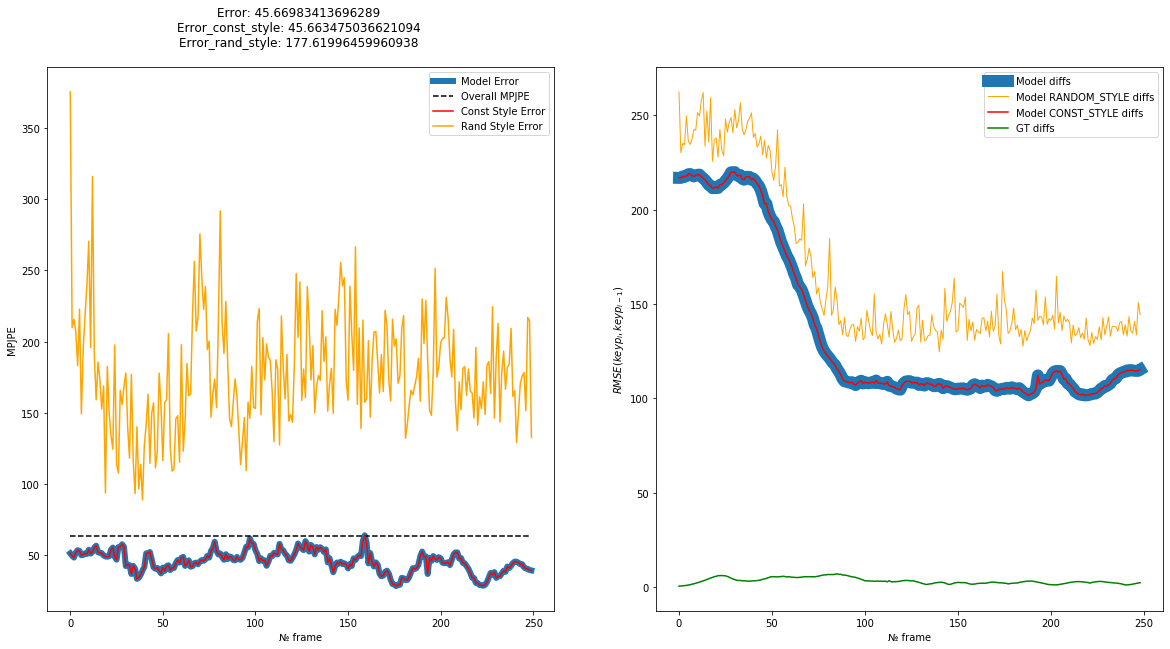

In [21]:
MPJPE = 63.6
#########
# ERROR #   
#########
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
error, gt_diffs, model_diffs = get_error_diffs(series['keypoints_gt'], series['keypoints'])
ax1.plot(error, label='Model Error', linewidth=6)
if MPJPE is not None:
    ax1.plot([MPJPE]*length, '--', color='black', label='Overall MPJPE')

title = f"Error: {error.mean()} \n"

if USE_CONSTANT_STYLE_VECTOR:
    error_const_style, _, model_diffs_const_style = get_error_diffs(series['keypoints_gt'], series['keypoints_const_style'])
    ax1.plot(error_const_style, 'red', label='Const Style Error')
    title += f"Error_const_style: {error_const_style.mean()} \n"

if USE_RANDOM_STYLE_VECTOR:
    error_rand_style, _, model_diffs_rand_style = get_error_diffs(series['keypoints_gt'], series['keypoints_random_style'])
    ax1.plot(error_rand_style, 'orange', label='Rand Style Error')
    title += f"Error_rand_style: {error_rand_style.mean()} \n"

ax1.set_xlabel('№ frame')
ax1.set_ylabel('MPJPE')
ax1.set_title(title)
ax1.legend()

#########
# DIFFS #   
#########
ax2.plot(model_diffs, label='Model diffs', linewidth=12)

if USE_RANDOM_STYLE_VECTOR:
    ax2.plot(model_diffs_rand_style, 'orange',label='Model RANDOM_STYLE diffs', linewidth=1)
if USE_CONSTANT_STYLE_VECTOR:
    ax2.plot(model_diffs_const_style, 'red',label='Model CONST_STYLE diffs')    

ax2.plot(gt_diffs, 'g', label='GT diffs')
ax2.set_xlabel('№ frame')
ax2.set_ylabel(r'$RMSE(keyp_{i}, keyp_{i-1})$')
ax2.legend()

In [22]:
# plt.figure()
# plt.plot(error)
# plt.plot(error_const_style, 'red')

# Debug

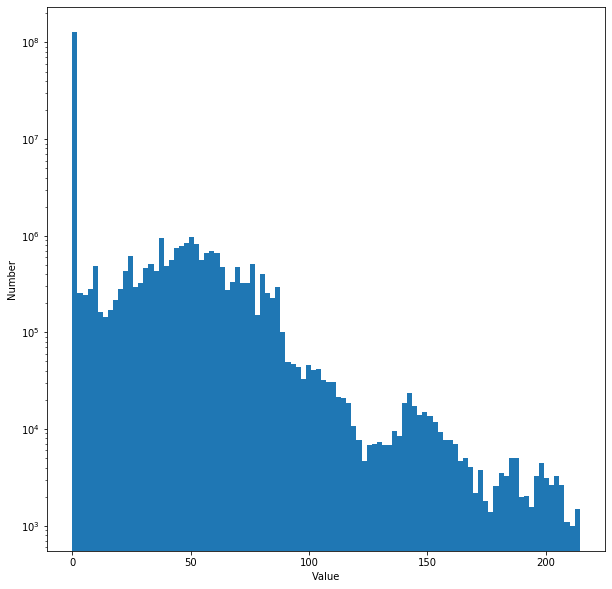

In [23]:
style_vectors = series['style_vectors']#.squeeze(1)
style_vectors_me = series['style_vectors_me']#.squeeze(1)

unproj_features = series['unproj_features']
plt.figure(figsize=(10,10))
plt.hist(style_vectors.flatten(), bins=100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Value')
plt.ylabel('Number')

# plt.show()
# plt.close('all')
plt.savefig(f"{os.path.join(experiment_root, 'hist')}", dpi=280)

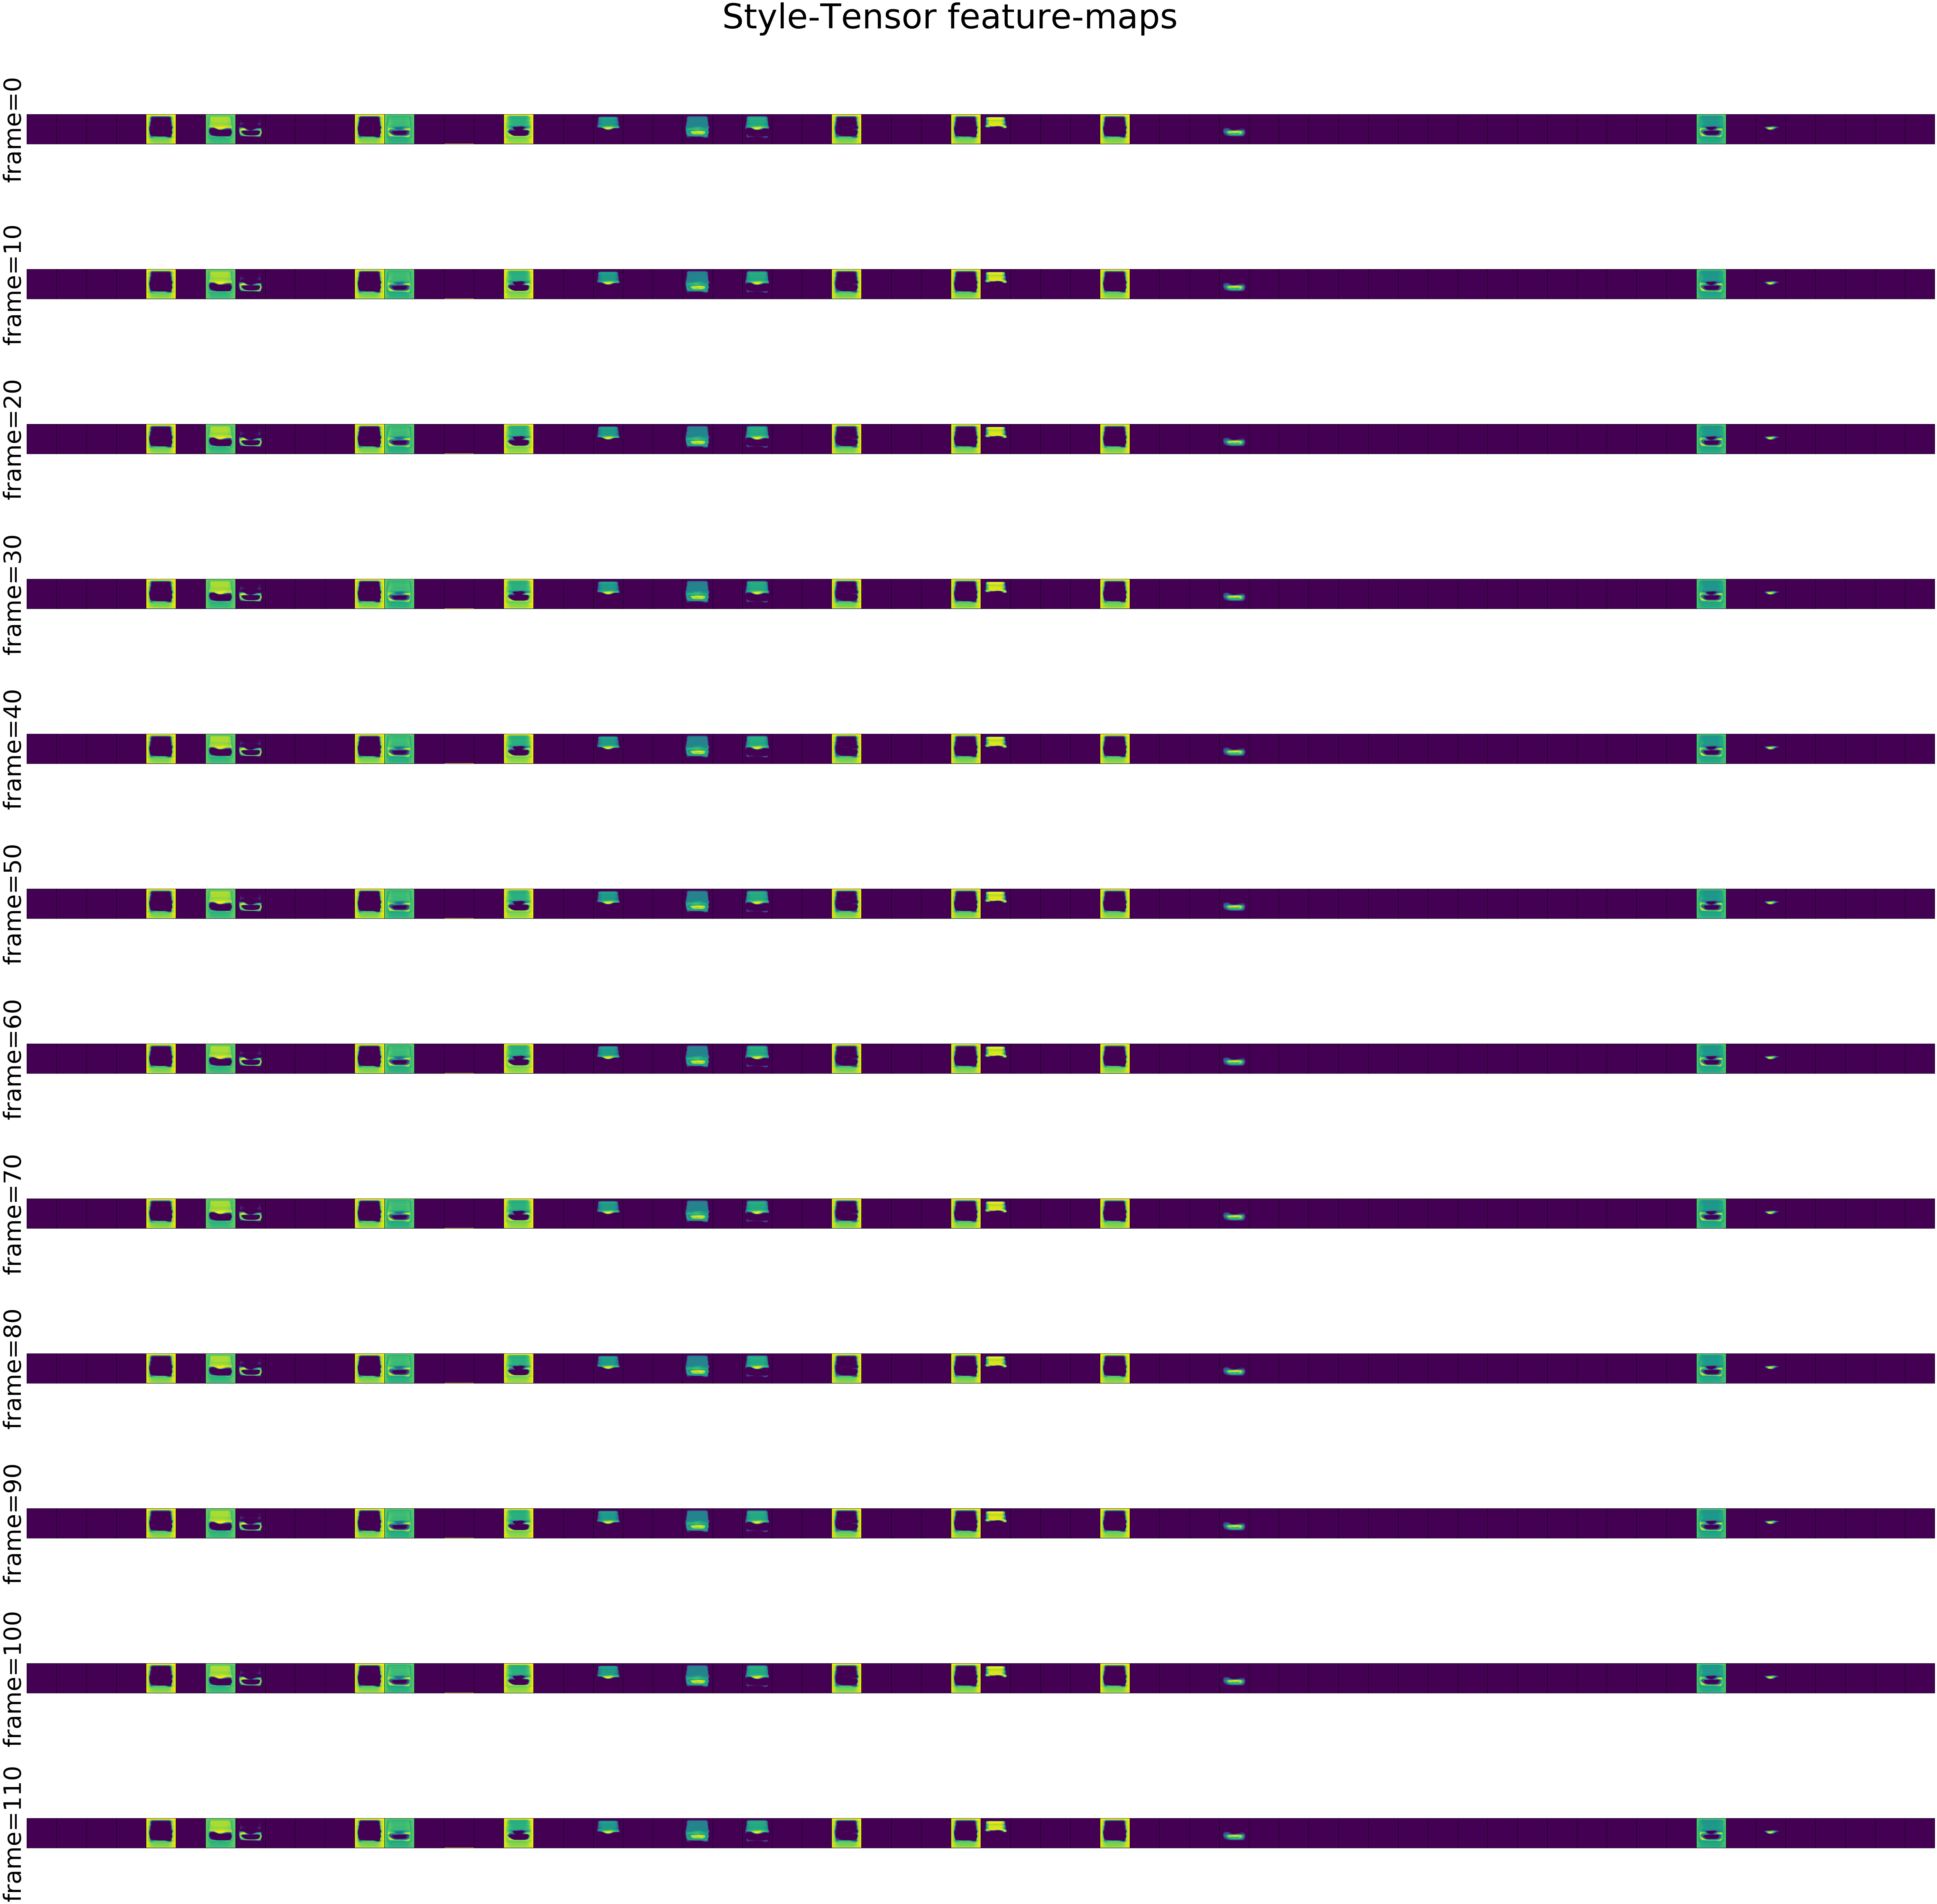

In [24]:
if series['style_vectors'].ndim == 2:
    plt.imshow(series['style_vectors'])
    plt.xlabel('feature index')
    plt.ylabel(r'$\leftarrow$№ frame')

elif series['style_vectors'].ndim == 4:
    n_frames = 12
    dilation = 10
#     style_channel = np.argmax([style_vectors[:,i,...].reshape(length, -1).ptp(0).max() \
#                                for i in range(style_vectors.shape[-3])])
    n_style_channels = style_vectors.shape[-3]
    fig, axes = plt.subplots(ncols=n_style_channels,
                             nrows=n_frames,
                             figsize=(100,100))
    for i in range(n_frames):
        for j in range(n_style_channels):
            t = i*dilation
            axes[i,j].imshow(style_vectors[t, j])
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
            if j == 0:
                axes[i,j].set_ylabel(f'frame={t}', fontsize=70)
    fig.subplots_adjust(hspace=0., wspace=0.)
    fig.suptitle('Style-Tensor feature-maps', fontsize=100, y = 0.9)
    plt.show()    
        
elif series['style_vectors'].ndim == 5:
    style_channel = np.argmax([style_vectors[:,i,...].reshape(length, -1).ptp(0).max() \
                               for i in range(style_vectors.shape[-3])])
    ptp = style_vectors[:, style_channel].reshape(length, -1).ptp(0).max()
    n_frames = 12
    dilation = 10
    n_style_channels = style_vectors.shape[-4]
    time_dimension = style_vectors.shape[-3]
    n = int(np.sqrt(n_style_channels))
    fig, axes = plt.subplots(ncols=time_dimension,
                             nrows=n_frames,
                             figsize=(100,100))
    for i in range(n_frames):    
        for j in range(time_dimension):
            t = i*dilation
            axes[i,j].imshow(style_vectors[t, style_channel, j])
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
            if j == 0:
                axes[i,j].set_ylabel(f'frame={t}', fontsize=70)
    fig.subplots_adjust(hspace=0., wspace=0.)
    fig.suptitle(f'Style-Tensor slices along first spatial dimension, with channel that gives maximal PTP={np.round(ptp,4)}', fontsize=100, y = 0.9)
    plt.show()
        

In [25]:
ptp = style_vectors.reshape(length, -1).ptp(0)
var = style_vectors.reshape(length, -1).var(0)

Text(0.5, 0, 'feature index')

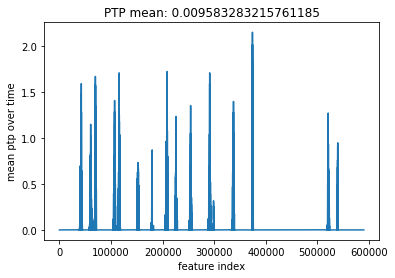

In [26]:
plt.plot(ptp)
plt.title(f'PTP mean: {ptp.mean()}')
plt.ylabel('mean ptp over time')
plt.xlabel('feature index')

Text(0.5, 0, 'feature index')

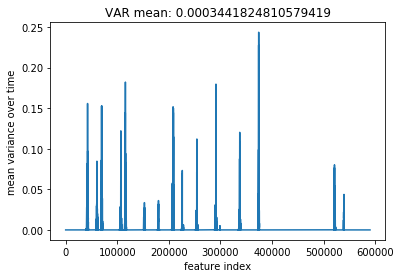

In [27]:
plt.plot(var)
plt.title(f'VAR mean: {var.mean()}')
plt.ylabel('mean variance over time')
plt.xlabel('feature index')


Text(0, 0.5, '$||s(t_i) - s(t_{i-1}) ||$')

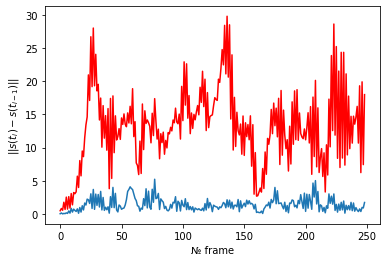

In [34]:
style_diffs = []
style_diffs_me = []
dilation = 1
for i in range(dilation,length):
    style_diffs.append(np.linalg.norm(style_vectors[i] - style_vectors[i-dilation]))
    style_diffs_me.append(np.linalg.norm(style_vectors_me[i] - style_vectors_me[i-dilation]))
plt.plot(style_diffs) 
plt.plot(style_diffs_me, 'r') 
plt.xlabel('№ frame')
plt.ylabel(r'$||s(t_i) - s(t_{i-1}) ||$')


In [29]:
i_max = range(dilation,length)[np.argmin(style_diffs)] 
diff = style_vectors[i_max] - style_vectors[i_max-1] 

TypeError: Invalid shape (96,) for image data

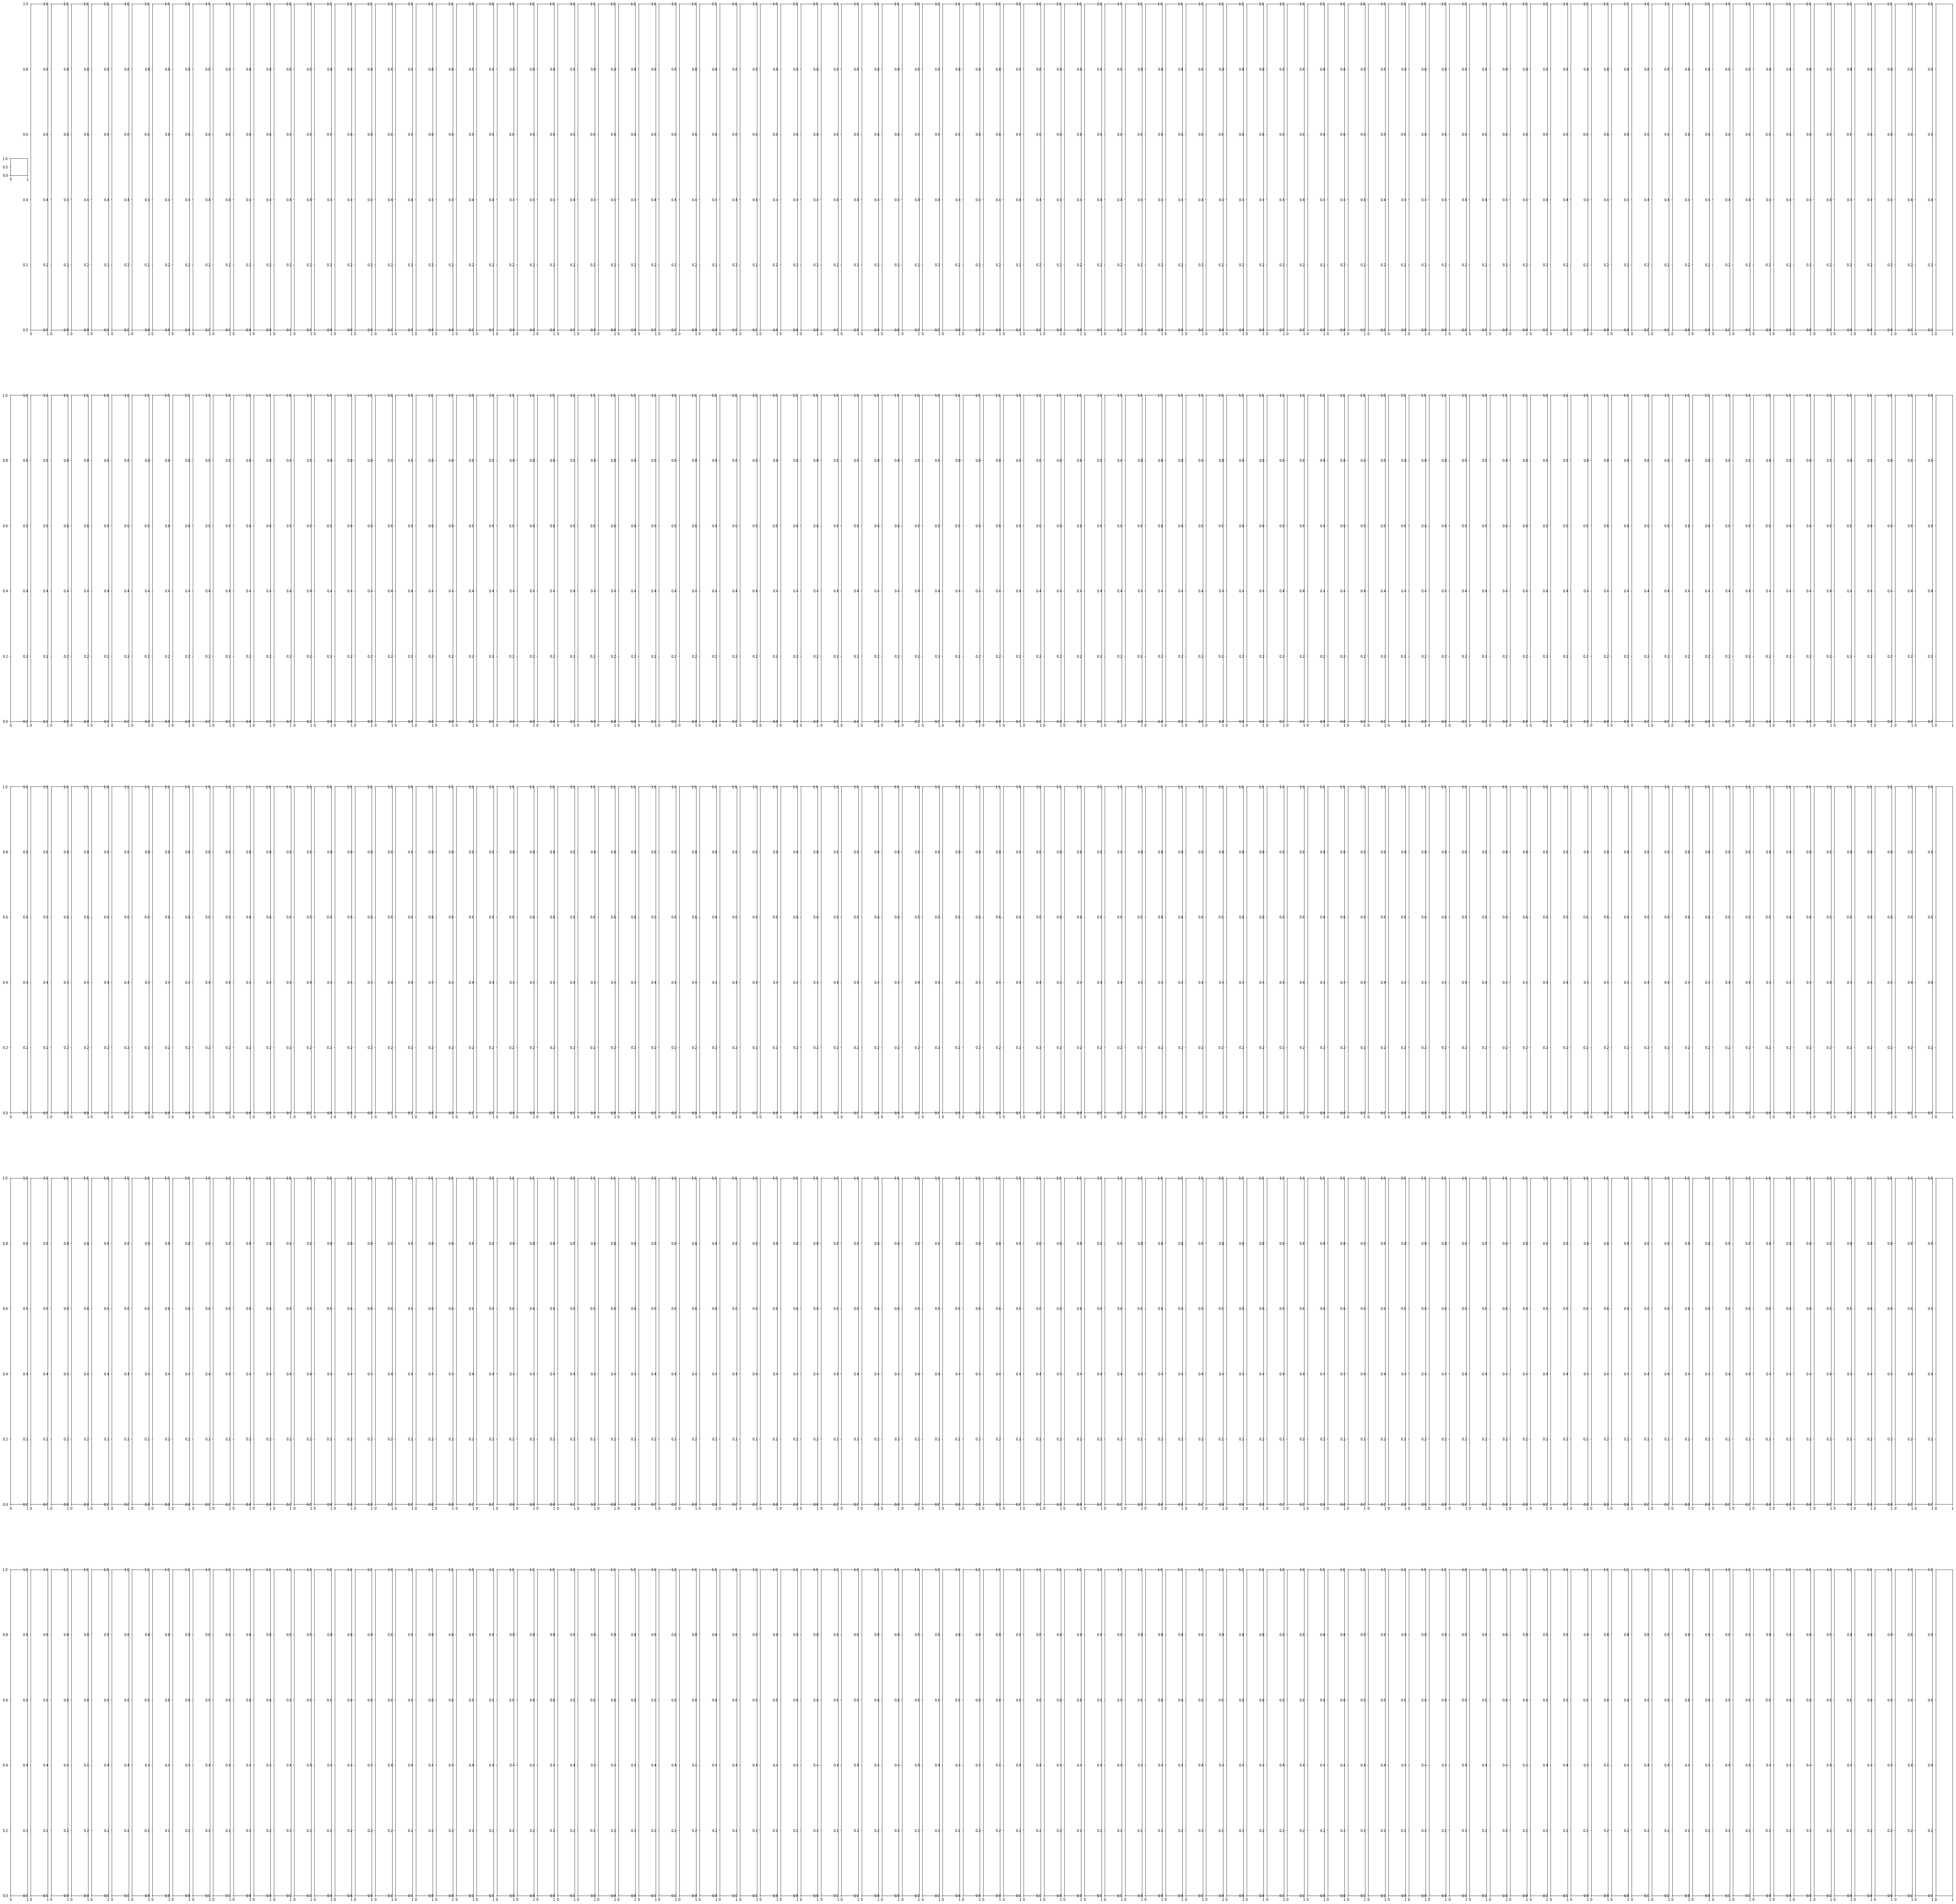

In [30]:
nrows = 5
fig, axes = plt.subplots(ncols=diff.shape[1],
                             nrows=nrows,
                             figsize=(100,100))
for i in range(nrows):    
    for j in range(diff.shape[1]):
        axes[i,j].imshow(diff[i,j])
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
plt.show()

In [ ]:
# fig, axes = plt.subplots(ncols=8,
#                              nrows=8,
#                              figsize=(100,100))

# for i in range(8):
#     for j in range(8):
#         axes[i,j].imshow(w1_flat_dim[:,i*8 + j,...])
#         axes[i,j].set_xticks([])
#         axes[i,j].set_yticks([])

In [ ]:
# for v in d['weight']:
#     plt.figure()
#     plt.hist(v.flatten(),bins=100)
# plt.show()    

# Post processing

In [ ]:
# from scipy.signal import savgol_filter, savgol_coeffs
# n_joints = series['keypoints'].shape[1]
# series['keypoints_smoothed'] = []
# for i in range(n_joints):
#     joint_coord_sequence = series['keypoints'][:,i]
#     series['keypoints_smoothed'] += [savgol_filter(joint_coord_sequence, window_length=25, polyorder = 2, axis=0)]
# series['keypoints_smoothed'] = np.stack(series['keypoints_smoothed'], 1)

In [ ]:
# coord=1
# joint = 3
# plt.plot(series['keypoints_smoothed'][:,joint,coord][:20],'r', label='smoothed')
# plt.plot(series['keypoints'][:,joint,coord][:20], label='original')
# plt.legend()

# Make Video

In [ ]:
# video_path = os.path.join('videos/',experiment_type, experiment_name)
# if not os.path.isdir(video_path):
#     os.makedirs(video_path)
#     print ('video_path - Created')
# else:
#     print ('video_path - Already exists')
    
# keypoints_dir = os.path.join(video_path,'{0}_{1}'.format(subject, action),'keypoints_videos_lowres')
# if not os.path.isdir(keypoints_dir):
#     os.makedirs(keypoints_dir)
#     print ('keypoints_dir - Created')
# else:
#     print ('keypoints_dir - Already exists')        

In [ ]:
# with_gt = True
# with_random_style = True
# add_per_joint_description = False
# for i in tqdm_notebook(range(1)):
#     fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (45,45))
#     for view in range(4):

#         # unpack
#         image = series['images'][view][i]
#         proj_matrice = series['proj_matrices'][view][i]
#         keypoints_3d_gt = series['keypoints_gt'][i]
#         keypoints_3d_pred = series['keypoints'][i] #if not with_random_style else series['keypoints_random_style'][i]

#         ax_i = ax.flatten()[view]
#         ax_i.imshow(image)

#         pjpe = np.linalg.norm(keypoints_3d_gt - keypoints_3d_pred, axis=-1)

#         # predicted keypoints
#         keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                     keypoints_3d_pred)
#         draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

#         if with_gt:
#             keypoints_2d_gt_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                         keypoints_3d_gt)
#             draw_2d_pose(keypoints_2d_gt_proj, ax_i,kind='human36m', point_size=200, line_width=5, color='g')

#         if view == eval_view and add_per_joint_description:
#             ax_i.set_title(f'EVAL_VIEW, MPJPE: {pjpe.mean()}', fontsize=34)
#             text = ''.join([j_name + f': ~{int(pjpe[j_n])}' + '\n' for j_n,j_name in JOINT_H36_DICT.items()])
#             h,w = image.shape[:2]
#             offset_1, offset_2 = 5,10
#             ax_i.text(0+offset_1, h-offset_2, text, style='italic', fontsize=25,
#             bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#     plt.show()      
# #     plt.savefig('./{}/img_{:05}.jpg'.format(keypoints_dir, i), bbox_inches='tight', dpi=100)
# #     plt.close('all')


# Compare Normal style winth Random style

In [ ]:
# keypoints_3d_pred_original
# keypoints_3d_ranom_style

# plt.fugure()
# # predicted keypoints
# keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                             keypoints_3d_pred_original)
# draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

# plt.fugure()
# # predicted keypoints
# keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                             keypoints_3d_ranom_style)
# draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

# Compare models video

In [ ]:
# video_path = os.path.join('videos/','baseline_vs_adain')
# if not os.path.isdir(video_path):
#     os.makedirs(video_path)
#     print ('video_path - Created')
# else:
#     print ('video_path - Already exists')
    
# keypoints_dir = os.path.join(video_path,'{0}_{1}'.format(subject, action),'keypoints_videos_lowres')
# if not os.path.isdir(keypoints_dir):
#     os.makedirs(keypoints_dir)
#     print ('keypoints_dir - Created')
# else:
#     print ('keypoints_dir - Already exists')        

In [ ]:
# series_baseline = np.load('action-Directions-1_subj-S9_l100-eval-0_model-vol.npy', allow_pickle=True).item()
# series_model = np.load('action-Directions-1_subj-S9_l100-eval-0_model-vol_temporal_adain.npy', allow_pickle=True).item()
# add_per_joint_description = False

# offset = abs(series_baseline['keypoints_gt'] - series_model['keypoints_gt'][0]).sum(-1).sum(-1).argmin()

# for i in tqdm_notebook(range(20)):

#     fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (45,45))
#     for view in range(4):

#         # unpack
#         image = series_model['images'][view][:-offset][i]
#         proj_matrice = series_model['proj_matrices'][view][:-offset][i]
        
#         keypoints_3d_baseline = series_baseline['keypoints'][offset:][i]
#         keypoints_3d_model = series_model['keypoints'][:-offset][i]
        
#         keypoints_3d_gt_model = series_model['keypoints_gt'][:-offset][i]
#         keypoints_3d_gt_baseline = series_baseline['keypoints_gt'][offset:][i]
        
#         assert (keypoints_3d_gt_model == keypoints_3d_gt_baseline).all()
        
#         ax_i = ax.flatten()[view]
#         ax_i.imshow(image)

#         pjpe_baseline = round(np.linalg.norm(keypoints_3d_gt_baseline - keypoints_3d_baseline, axis=-1).mean(),2)
#         pjpe_model = round(np.linalg.norm(keypoints_3d_gt_model - keypoints_3d_model, axis=-1).mean(),2)
        
#         # predicted keypoints
#         keypoints_2d_baseline_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                          keypoints_3d_baseline)
#         draw_2d_pose(keypoints_2d_baseline_proj,ax_i,kind='human36m', point_size=200, line_width=5)

#         keypoints_2d_model_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                     keypoints_3d_model)
#         draw_2d_pose(keypoints_2d_model_proj, ax_i,kind='human36m', point_size=200, line_width=5, color='g')
    
#         ax_i.set_title(f'MPJPE: model-{pjpe_model}, baseline-{pjpe_baseline}', fontsize=34)
    
    
#     plt.savefig('./{}/img_{:05}.jpg'.format(keypoints_dir, i), bbox_inches='tight')
#     plt.close()        
